In [1]:
# Import dependencies
from scipy.io import wavfile
from sklearn.svm import SVC
from scipy.signal import spectrogram
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from pathlib import Path

import glob
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
import random
#assert tf.__version__ == "1.7.0"
#tf.logging.set_verbosity(tf.logging.INFO)


In [2]:
dataset = [{'path': path, 'label': path.split('/' )[4] } for path in glob.glob("../../dataset_heart_sound/PV/**/*.wav")]
df = pd.DataFrame.from_dict(dataset)
print(dataset[0])

# Add a column to store the data read from each wavfile...   
df['x'] = df['path'].apply(lambda x: wavfile.read(x)[1])
df.head()

{'path': '../../dataset_heart_sound/PV/abnormal/85262_PV.wav', 'label': 'abnormal'}


,path,label,x
0,../../dataset_heart_sound/PV/abnormal/85262_PV...,abnormal,"[0, -174, -735, -850, -324, -132, -105, -86, -..."
1,../../dataset_heart_sound/PV/abnormal/85133_PV...,abnormal,"[1876, -891, -6477, -9487, -7455, -3722, -3318..."
2,../../dataset_heart_sound/PV/abnormal/68909_PV...,abnormal,"[-1161, -558, 572, -121, -28, 157, 204, -150, ..."
3,../../dataset_heart_sound/PV/abnormal/50125_PV...,abnormal,"[288, 430, -478, 436, 339, -88, 134, -6, 80, 1..."
4,../../dataset_heart_sound/PV/abnormal/68347_PV...,abnormal,"[25, 129, -446, -3723, -7896, -10844, -13023, ..."


# Sample class audio plot 

Displaying all three kinds of audio classes normal, abnormal and extrasystole. We can see different patters in various classes.


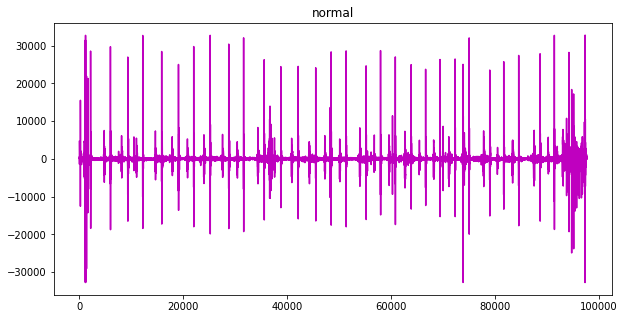

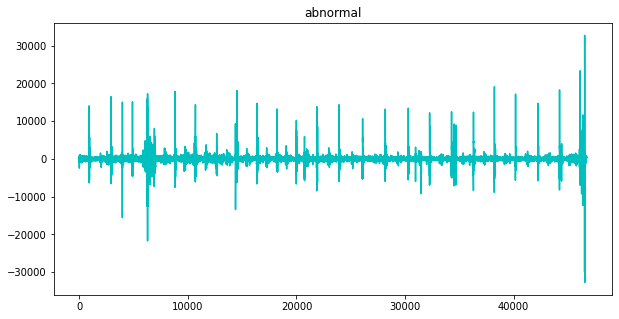

In [3]:
#Choosing one of the each samples form each catogery 
normal = df[df['label'] == 'normal' ].sample(1)
abnormal = df[df['label'] == 'abnormal' ].sample(1)
#extrasystole = df[df['label'] == 'extsys' ].sample(1)

# Plot the three samples onto three different figures
plt.figure(1, figsize=(10,5))
plt.title('normal')
plt.plot(normal['x'].values[0], c='m')

plt.figure(2, figsize=(10, 5))
plt.title('abnormal')
plt.plot(abnormal['x'].values[0], c='c')

#plt.figure(3, figsize=(10, 5))
#plt.title('extrasystole')
#plt.plot(extrasystole['x'].values[0], c='b')

In [4]:
#make the lenght of all audio files same by repeating audio file contents till its length is equal to max length audio file
max_length = max(df['x'].apply(len))

# Kaggle: What's in a heartbeat? - Peter Grenholm
def repeat_to_length(arr, length):
    """Repeats the numpy 1D array to given length, and makes datatype float"""
    result = np.empty((length, ), dtype = np.float32)
    l = len(arr)
    pos = 0
    while pos + l <= length:
        result[pos:pos+l] = arr
        pos += l
    if pos < length:
        result[pos:length] = arr[:length-pos]
    return result

df['x'] = df['x'].apply(repeat_to_length, length=max_length)
df.head()

,path,label,x
0,../../dataset_heart_sound/PV/abnormal/85262_PV...,abnormal,"[0.0, -174.0, -735.0, -850.0, -324.0, -132.0, ..."
1,../../dataset_heart_sound/PV/abnormal/85133_PV...,abnormal,"[1876.0, -891.0, -6477.0, -9487.0, -7455.0, -3..."
2,../../dataset_heart_sound/PV/abnormal/68909_PV...,abnormal,"[-1161.0, -558.0, 572.0, -121.0, -28.0, 157.0,..."
3,../../dataset_heart_sound/PV/abnormal/50125_PV...,abnormal,"[288.0, 430.0, -478.0, 436.0, 339.0, -88.0, 13..."
4,../../dataset_heart_sound/PV/abnormal/68347_PV...,abnormal,"[25.0, 129.0, -446.0, -3723.0, -7896.0, -10844..."


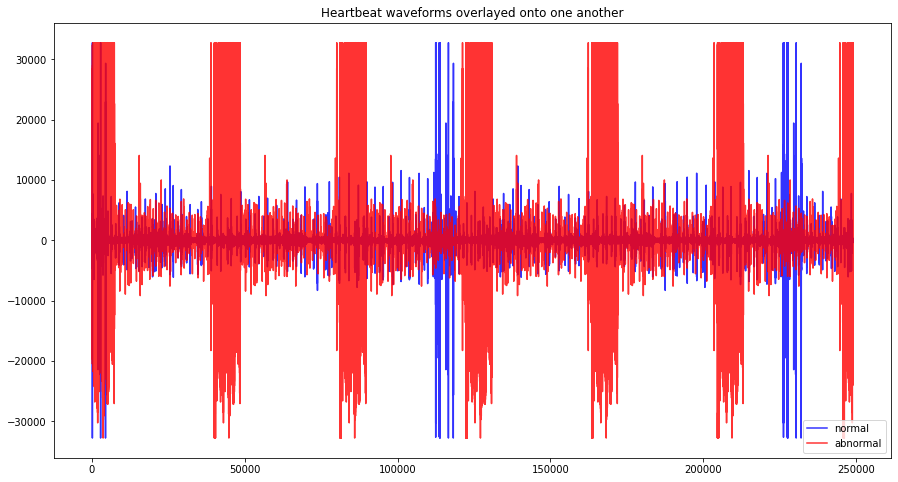

In [5]:
# Collect one sample from each of the three classes and plot their waveforms
normal = df[df['label'] == 'normal' ].sample(1)
abnormal = df[df['label'] == 'abnormal' ].sample(1)
#extrasystole = df[df['label'] == 'extsys' ].sample(1)

plt.figure(1, figsize=(15,8))
plt.plot(normal['x'].values[0], c='b', label='normal', alpha=0.8)
plt.plot(abnormal['x'].values[0], c='r', label='abnormal', alpha=0.8)
#plt.plot(extrasystole['x'].values[0], c='g', label='extrasystole', alpha=0.8)

plt.title('Heartbeat waveforms overlayed onto one another')
plt.legend(loc='lower right')
# plt.savefig('temp.png')

"\nf_extra, t_extra, Sxx_extra = spectrogram(extrasystole['x'].values[0], 4000)\nplt.figure(3, figsize=(20, 5))\nplt.title('Extrasystole')\nplt.pcolormesh(t_extra, f_extra, Sxx_extra, cmap='Spectral')\nplt.ylabel('Frequency [Hz]')\nplt.xlabel('Time [sec]')\n"

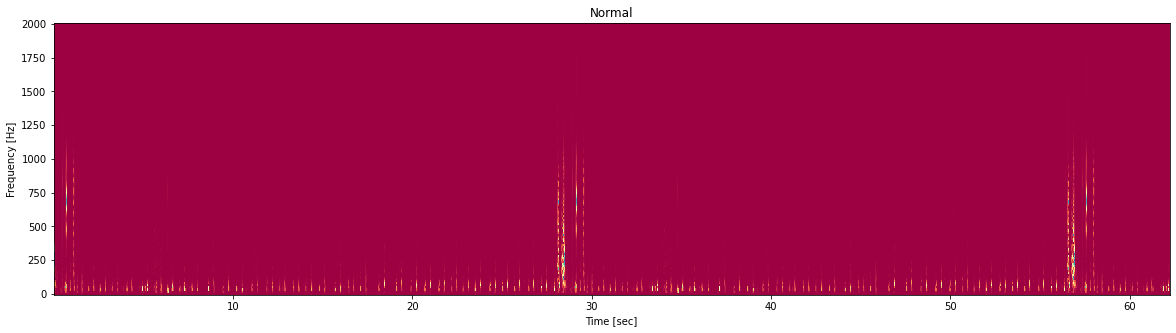

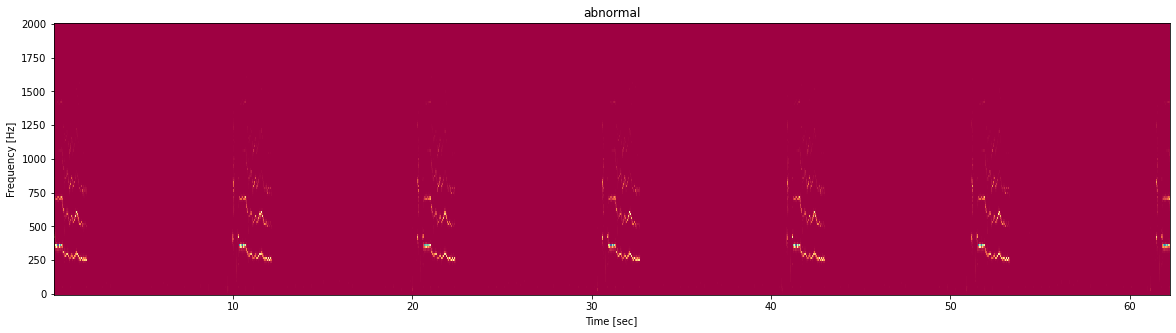

In [6]:
fs = 4000
f_normal, t_normal, Sxx_normal = spectrogram(normal['x'].values[0], 4000)
plt.figure(1, figsize=(20,5))
plt.title('Normal')
plt.pcolormesh(t_normal, f_normal, Sxx_normal, cmap='Spectral')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

f_abnormal, t_abnormal, Sxx_abnormal = spectrogram(abnormal['x'].values[0], 4000)
plt.figure(2, figsize=(20, 5))
plt.title('abnormal')
plt.pcolormesh(t_abnormal, f_abnormal, Sxx_abnormal, cmap='Spectral')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

"""
f_extra, t_extra, Sxx_extra = spectrogram(extrasystole['x'].values[0], 4000)
plt.figure(3, figsize=(20, 5))
plt.title('Extrasystole')
plt.pcolormesh(t_extra, f_extra, Sxx_extra, cmap='Spectral')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
"""

In [7]:
# Put the data into numpy arrays. Most machine learning libraries use numpy arrays.
x = np.stack(df['x'].values, axis=0)
y = np.stack(df['label'].values, axis=0)

In [8]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test, train_filenames, test_filenames = train_test_split(x, df['label'].values, df['path'].values, train_size = 0.4, test_size=0.2)
print("x_train: {0}, x_test: {1}".format(x_train.shape, x_test.shape))

x_train = x_train[:, 30000:100000]

x_test = x_test[:, 30000:100000]

print("x_train: {0}, x_test: {1}".format(x_train.shape, x_test.shape))

x_train: (304, 248960), x_test: (153, 248960)
x_train: (304, 70000), x_test: (153, 70000)


In [9]:
clf = SVC()


In [10]:
clf.fit(x_train, y_train)


SVC()

In [11]:
predictions = clf.predict(x_test)
print("Accuracy %.3f" % accuracy_score(y_test, predictions))

Accuracy 0.529


In [12]:
clf = MLPClassifier(hidden_layer_sizes=(1024,512,256,128,), 
                    max_iter=5000, verbose=True)
clf.fit(x_train, y_train)
predictions = clf.predict(x_test)
print("Accuracy %.3f" % accuracy_score(y_test, predictions))

Iteration 1, loss = 7.40104382
Iteration 2, loss = 7.49988621
Iteration 3, loss = 3.98680254
Iteration 4, loss = 0.10616685
Iteration 5, loss = 1.52280815
Iteration 6, loss = 0.36852564
Iteration 7, loss = 0.00149728
Iteration 8, loss = 0.00155652
Iteration 9, loss = 0.15893494
Iteration 10, loss = 0.00165430
Iteration 11, loss = 0.00169364
Iteration 12, loss = 0.00172738
Iteration 13, loss = 0.00175610
Iteration 14, loss = 0.00178044
Iteration 15, loss = 0.00180102
Iteration 16, loss = 0.00181835
Iteration 17, loss = 0.00183292
Iteration 18, loss = 0.00184514
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy 0.536


In [13]:
# Convert data to the format tf.keras expects
x_train = x_train[:,:,np.newaxis]
x_test = x_test[:,:,np.newaxis]
x_train.shape

(304, 70000, 1)

# CNN Model

In [14]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv1D(filters=4, kernel_size=9, activation='relu',
                input_shape = x_train.shape[1:]))
model.add(tf.keras.layers.MaxPool1D(strides=4))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv1D(filters=4, kernel_size=9, activation='relu'))
model.add(tf.keras.layers.MaxPool1D(strides=4))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv1D(filters=8, kernel_size=9, activation='relu'))
model.add(tf.keras.layers.MaxPool1D(strides=4))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=9, activation='relu'))
model.add(tf.keras.layers.MaxPool1D(strides=4))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=9, activation='relu'))
model.add(tf.keras.layers.MaxPool1D(strides=4))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=9, activation='relu'))
model.add(tf.keras.layers.MaxPool1D(strides=4))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.7))
model.add(tf.keras.layers.GlobalAvgPool1D())
model.add(tf.keras.layers.Dense(2, activation='softmax'))

2022-09-02 01:54:19.787400: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-02 01:54:19.834199: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-02 01:54:19.834415: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-02 01:54:19.841149: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [15]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [16]:
# Need to convert y labels into one-hot encoded vectors
y_train_int_categories, y_train_class_names = pd.factorize(y_train)
print("y_train_class_names: {0}".format(y_train_class_names))

y_test_int_categories, y_test_class_names = pd.factorize(y_test)
print("y_test_class_names: {0}".format(y_test_class_names))
y_train_hot = tf.keras.utils.to_categorical(y_train_int_categories)
y_test_hot = tf.keras.utils.to_categorical(y_test_int_categories)

hist = model.fit(x_train, y_train_hot, 
                 epochs=100,
                 validation_data=(x_test, y_test_hot), verbose=1)

y_train_class_names: ['normal' 'abnormal']
y_test_class_names: ['abnormal' 'normal']


2022-09-02 01:54:20.848247: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 85120000 exceeds 10% of free system memory.
2022-09-02 01:54:20.998321: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 85120000 exceeds 10% of free system memory.


Epoch 1/100


2022-09-02 01:54:22.600187: E tensorflow/stream_executor/cuda/cuda_dnn.cc:389] Could not create cudnn handle: CUDNN_STATUS_INTERNAL_ERROR
2022-09-02 01:54:22.601039: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at conv_ops.cc:1120 : UNIMPLEMENTED: DNN library is not found.


UnimplementedError: Graph execution error:

Detected at node 'sequential/conv1d/Conv1D' defined at (most recent call last):
    File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/usr/local/lib/python3.8/dist-packages/traitlets/config/application.py", line 976, in launch_instance
      app.start()
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/usr/local/lib/python3.8/dist-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_494562/45084388.py", line 10, in <cell line: 10>
      hist = model.fit(x_train, y_train_hot,
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 889, in train_step
      y_pred = self(x, training=True)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/sequential.py", line 374, in call
      return super(Sequential, self).call(inputs, training=training, mask=mask)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py", line 458, in call
      return self._run_internal_graph(
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/layers/convolutional/base_conv.py", line 250, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "/usr/local/lib/python3.8/dist-packages/keras/layers/convolutional/base_conv.py", line 225, in convolution_op
      return tf.nn.convolution(
Node: 'sequential/conv1d/Conv1D'
DNN library is not found.
	 [[{{node sequential/conv1d/Conv1D}}]] [Op:__inference_train_function_3191]

# Plot of accuracy and loss

In [ ]:
accuracy = hist.history['accuracy']
loss = hist.history['loss']
val_accuracy = hist.history['val_accuracy']
val_loss = hist.history['val_loss']

plt.figure(1, figsize=(10, 5))
plt.title('CNN - Accuracy Curves')
plt.plot(accuracy, c='m')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.figure(2, figsize=(10, 5))
plt.title('CNN - Loss Curves')
plt.plot(loss, c='m')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.figure(3, figsize=(10, 5))
plt.title('CNN - val_Accuracy Curves')
plt.plot(val_accuracy, c='m')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.figure(4, figsize=(10, 5))
plt.title('CNN - val_Loss Curves')
plt.plot(val_loss, c='m')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.show()

In [ ]:
import time
start = time.time()*1000
model.predict(x_test)
end = time.time()*1000
total = end - start
print("Total prediction time (milliseconds) for %d samples: %f" % (len(x_test), total))
print("Average prediction time for one example: %f" % (total/len(x_test)))

In [ ]:
# Save the train model
tf.keras.models.save_model(
    model,
    filepath='C:/Users/apt/Desktop/save_model',
    overwrite=True,
    include_optimizer=True
)